<a href="https://colab.research.google.com/github/kmunozforti/Compass/blob/master/Copy_of_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compass Analysis

# New Section

This notebook gives a small demo of analyzing the results of the compass algorithm and replicates figures 2E and 2C from the paper.

To install the required python packages, you can uncomment the "install_reqs()" call.

In [3]:
def install_reqs():
  !pip install pandas
  !pip install "matplotlib>=3.4"
  !pip install numpy
  !pip install statsmodels
  !pip install scipy
#install_reqs()

In [5]:
import sys
if "google.colab" in sys.modules:
  !git clone -b docs https://github.com/YosefLab/Compass.git --depth 1
  !cp -r Compass/notebooks/extdata ./
  !cp /content/Compass/notebooks/compass_analysis.py /content/compass_analysis.py
  !rm -r /content/Compass
  install_reqs()

Cloning into 'Compass'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 113 (delta 8), reused 63 (delta 2), pack-reused 0
Receiving objects: 100% (113/113), 78.51 MiB | 42.67 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from compass_analysis import cohens_d, wilcoxon_test, get_reaction_consistencies, get_metareactions, labeled_reactions, amino_acid_metab

In [7]:
from matplotlib import __version__ as matplotlibversion
if matplotlibversion < "3.4":
    print("Matplotlib versions older than 3.4 may not be able to generate figure 2E, as they do not support alpha arrays")

The file "extdata/Th17/reactions.tsv" is the outputs of a compass run and "extdata/Th17/cell_metadata.csv" is cell metadata, in this case it is only used to know the condition of the Th17 cells (pathogenic vs. non-pathogenic). Commented out are alternative files to use for a microcpooled example.

In [8]:
reaction_penalties = pd.read_csv("extdata/Th17/CAFs/reactions_CAFs.csv", sep="\,", index_col = 0)


<ipython-input-8-00666ea7f611>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  reaction_penalties = pd.read_csv("extdata/Th17/CAFs/reactions_CAFs.csv", sep="\,", index_col = 0)


In [9]:
cell_metadata = pd.read_csv("extdata/Th17/CAFs/cell_metadata.csv", index_col = 0)


In [10]:


DP_CAFs = cell_metadata.index[cell_metadata['cell_type'] == 'DP']
iCAFs = cell_metadata.index[cell_metadata['cell_type'] == 'iCAFs']
apCAFs = cell_metadata.index[cell_metadata['cell_type'] == 'apCAFs']
myCAFs = cell_metadata.index[cell_metadata['cell_type'] == 'myCAFs']

The reaction metadata for RECON2 is stored here. We'll be using the confidence scores and the subsystem groupings to filter out reactions and group them for analysis.

In [52]:
reaction_metadata = pd.read_csv("extdata/RECON2/reaction_metadata.csv", index_col = 0)

Here is one example of a row for the reaction metadata:

In [53]:
reaction_metadata.loc[['r0281']]

,reaction_name,formula,associated_genes,subsystem,EC_number,confidence
reaction_no_direction,,,,,,
r0281,Putrescine:oxygen oxidoreductase (deaminating)...,1.00 * Water [e] + 1.00 * O2 [e] + 1.00 * Putr...,AOC1,Methionine and cysteine metabolism,1.4.3.6,0.0


The numbers in the reactions tsv correspond to penalties for each reaction per cell, so we take the negative log to get scores that are higher the more active the reaction is predicted to be. This also drops reactions that are close to constant and therefore not informative for the comparison.

In [54]:
#This function is repeated here for clarity
def get_reaction_consistencies(compass_reaction_penalties, min_range=1e-3):
    """
        Converts the raw penalties outputs of compass into scores per reactions where higher numbers indicate more activity
    """
    df = -np.log(compass_reaction_penalties + 1)
    df = df[df.max(axis=1) - df.min(axis=1) >= min_range]
    df = df - df.min().min()
    return df

In [55]:
reaction_consistencies = get_reaction_consistencies(reaction_penalties)

We use the unpaired Wilcoxon rank-sum test (equivlanet to the Mann–Whitney U test) to analyze which reactions are predicted to be more active in pathogenic Th17p cells compared to the non-pathogenic Th17n cells. Positive values indicate higher potential activity in Th17p.

In [57]:
wilcox_results = wilcoxon_test(reaction_consistencies, iCAFs, myCAFs)
wilcox_results['metadata_r_id'] = ""
for r in wilcox_results.index:
    if r in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur")

Next we join the metadata to the reactions in a new dataframe W, so that we can filter out non-core reactions. More specifically, we remove reactions with confidence other than 0 or 4 (4 = most confident; 0 = unassigned confidence) and filter out reactions in the citric acid cycle subsystem which are outside of the mitochondria.

In [58]:
W = wilcox_results.merge(reaction_metadata, how='left',
                         left_on='metadata_r_id', right_index=True, validate='m:1')
W = W[W['confidence'].isin([0,4])]
W = W[~W['EC_number'].isna()]
W.loc[(W['formula'].map(lambda x: '[m]' not in x)) & (W['subsystem'] == "Citric acid cycle"), 'subsystem'] = 'Other'

Here is one example of a row of the reuslting dataframe for a reaction:

In [59]:
wilcox_results.loc[['r0281_pos']]

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval,metadata_r_id
r0281_pos,49.0,0.000583,2.563807,0.004865,r0281


The "_neg" or "_pos" suffixes indicate one direction of a bidirectional reaction. The "_pos" direction indicates positive flux through the reaction. For this example reaction it indicates water, oxygen, and putrescine are being consumed by this reaction to produce ammonium, hyrodgen peroxide, and 4-Aminobutanal.

In [60]:
reaction_metadata.loc['r0281']['formula']

'1.00 * Water [e] + 1.00 * O2 [e] + 1.00 * Putrescine [e] --> 1.00 * Ammonium [e] + 1.00 * Hydrogen peroxide [e] + 1.00 * 4-Aminobutanal [e]\nAOC1'

### Optional: Metareaction analysis
[Metareactions](#Metareactions) are used in the paper rather than single reaction analysis and the section at the bottom of this notebook performs the same analysis using reactions clustered into metareactions.

### Figure 2C replication

In [61]:
def plot_differential_scores(data, title, c):
    plt.figure(figsize=(10,10))
    axs = plt.gca()
    axs.scatter(data['cohens_d'], -np.log10(data['adjusted_pval']), c=c)
    axs.set_xlabel("Cohen's d", fontsize=16)
    axs.set_ylabel("-log10 (Wilcoxon-adjusted p)", fontsize=16)
    #Everything after this should be tweaked depending on your application
    axs.set_xlim(-5.2, 5.2)
    axs.axvline(0, dashes=(3,3), c='black')
    axs.axhline(1, dashes=(3,3), c='black')
    axs.set_title(title, fontdict={'fontsize':20})
    axs.annotate('', xy=(0.5, -0.08), xycoords='axes fraction', xytext=(0, -0.08),
            arrowprops=dict(arrowstyle="<-", color='#348C73', linewidth=4))
    axs.annotate('iCAFs', xy=(0.75, -0.12), xycoords='axes fraction', fontsize=16)
    axs.annotate('', xy=(0.5, -0.08), xycoords='axes fraction', xytext=(1, -0.08),
            arrowprops=dict(arrowstyle="<-", color='#E92E87', linewidth=4))
    axs.annotate('myCAFs', xy=(0.25, -0.12), xycoords='axes fraction', fontsize=16)
    for r in data.index:
        if r in labeled_reactions:
            x = data.loc[r, 'cohens_d']
            y = -np.log10(data.loc[r, 'adjusted_pval'])
            offset = (60, 0)
            if x < 0:
                offset = (-100, -40)
            axs.annotate(labeled_reactions[r], (x,y), xytext = offset,
                         textcoords='offset pixels', arrowprops={'arrowstyle':"-"})

In [62]:
filtered_data = pd.concat([W[W['subsystem'] == "Glycolysis/gluconeogenesis"],
             W[W['subsystem'] == "Citric acid cycle"],
            W[W['subsystem'].isin(amino_acid_metab)],
           W[W['subsystem'] == "Fatty acid oxidation"]])

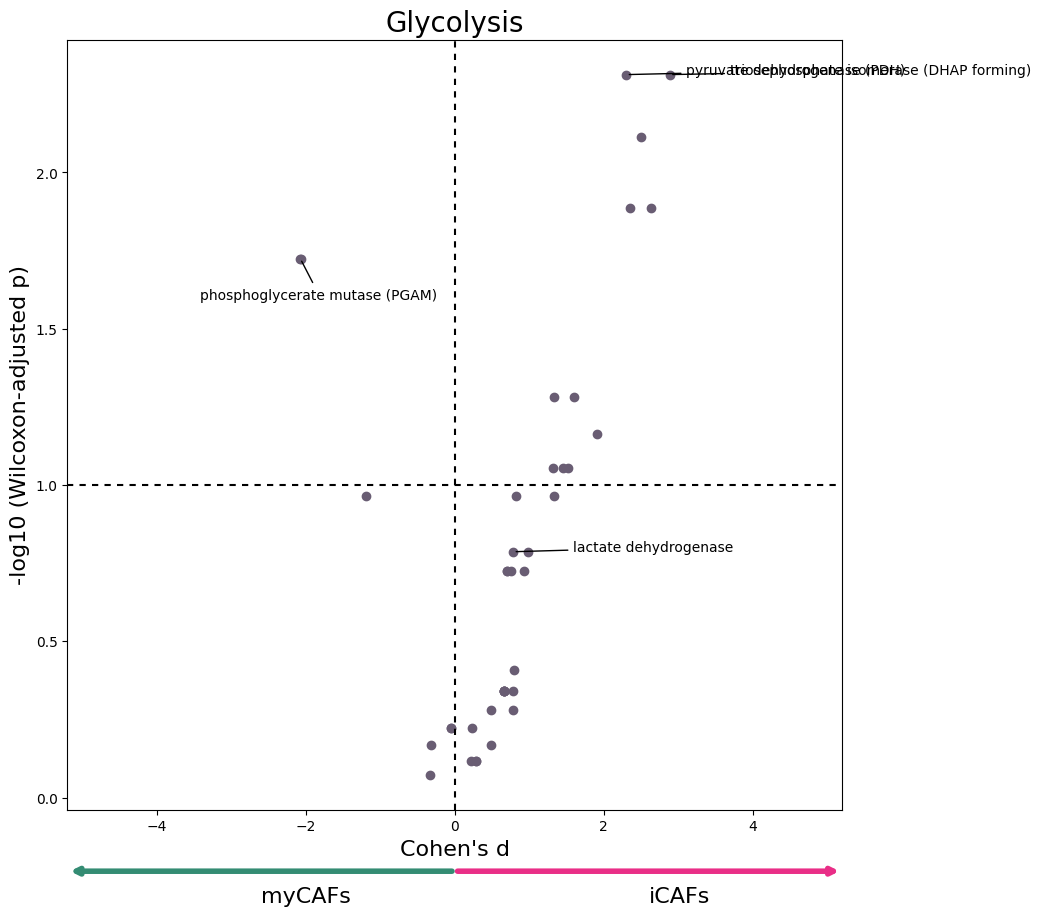

In [63]:
data = W[W['subsystem'] == "Glycolysis/gluconeogenesis"]
plot_differential_scores(data, title='Glycolysis', c="#695D73")

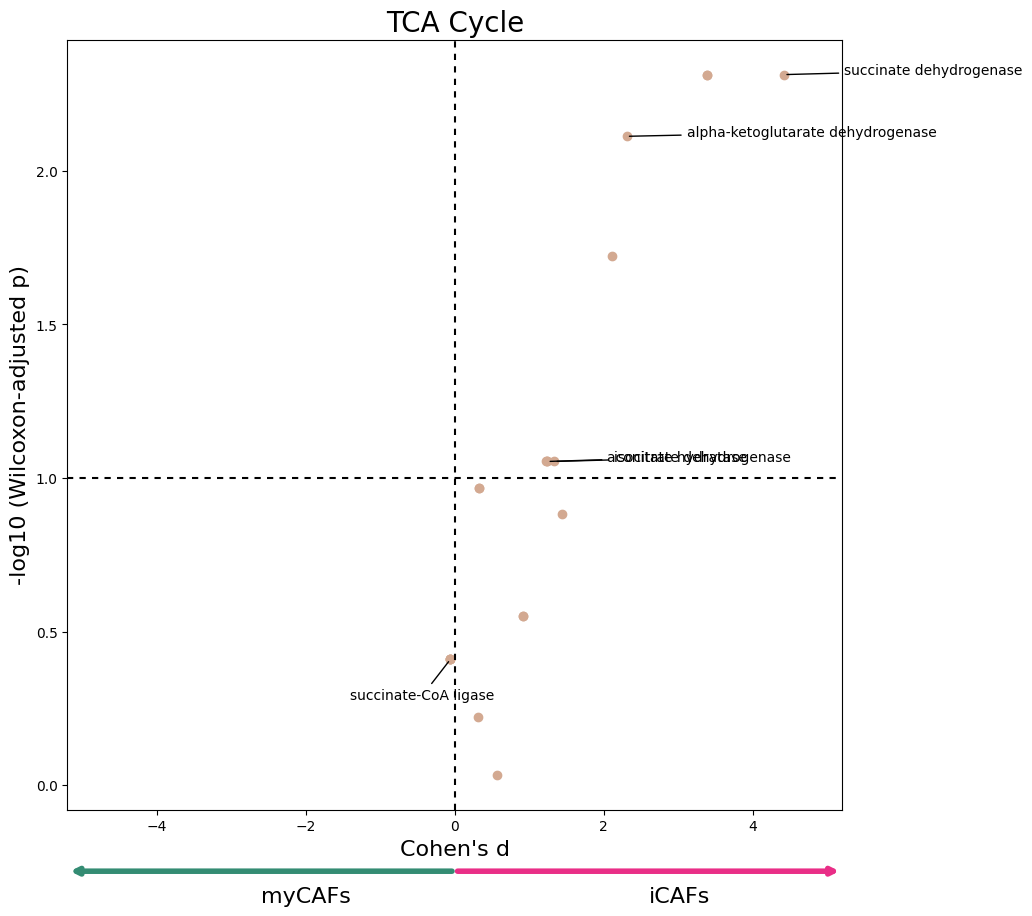

In [64]:
data = W[W['subsystem'] == "Citric acid cycle"]
plot_differential_scores(data, title="TCA Cycle", c="#D3A991")

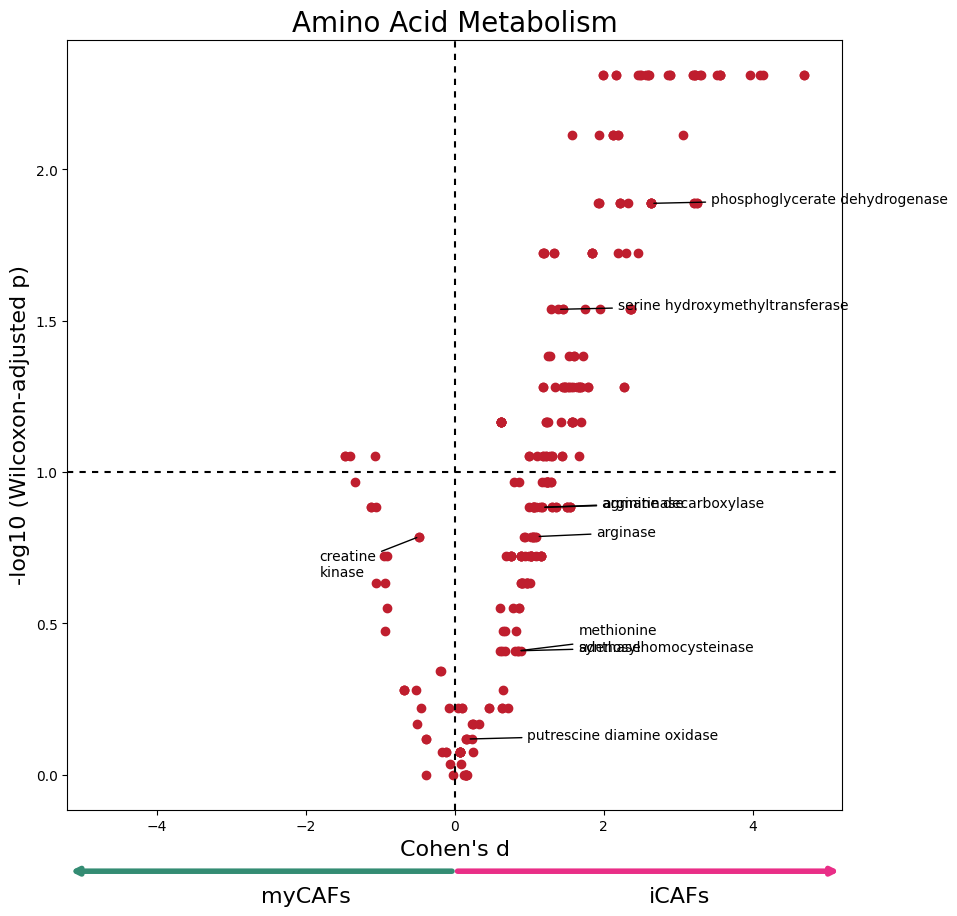

In [69]:
data = W[W['subsystem'].isin(amino_acid_metab)].copy()
data['adjusted_pval'] = data['adjusted_pval'].clip(1e-12)
plot_differential_scores(data, "Amino Acid Metabolism", c="#BF1E2E")

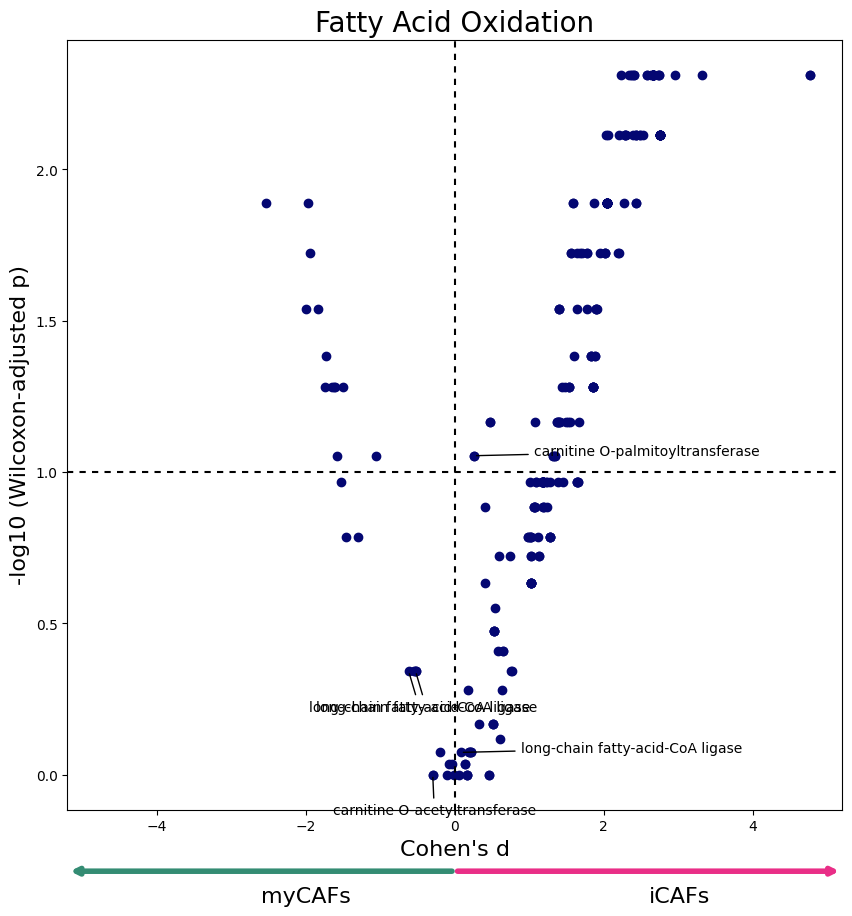

In [70]:
data = W[W['subsystem'] == "Fatty acid oxidation"]
plot_differential_scores(data, "Fatty Acid Oxidation", c="#040772")

### Figure 2E replication

In [67]:
data = W[~W['subsystem'].isin(["Miscellaneous", "Unassigned"])]
data = data[~data['subsystem'].map(lambda x: "Transport" in x or "Exchange" in x or x == "Other")]
items, counts = np.unique(data['subsystem'], return_counts=True)
items = [items[i] for i in range(len(items)) if counts[i] > 5] #filter(n() > 5) %>%
data = data[data['subsystem'].isin(items)]

Text(0.5, 0, "Cohen's d")

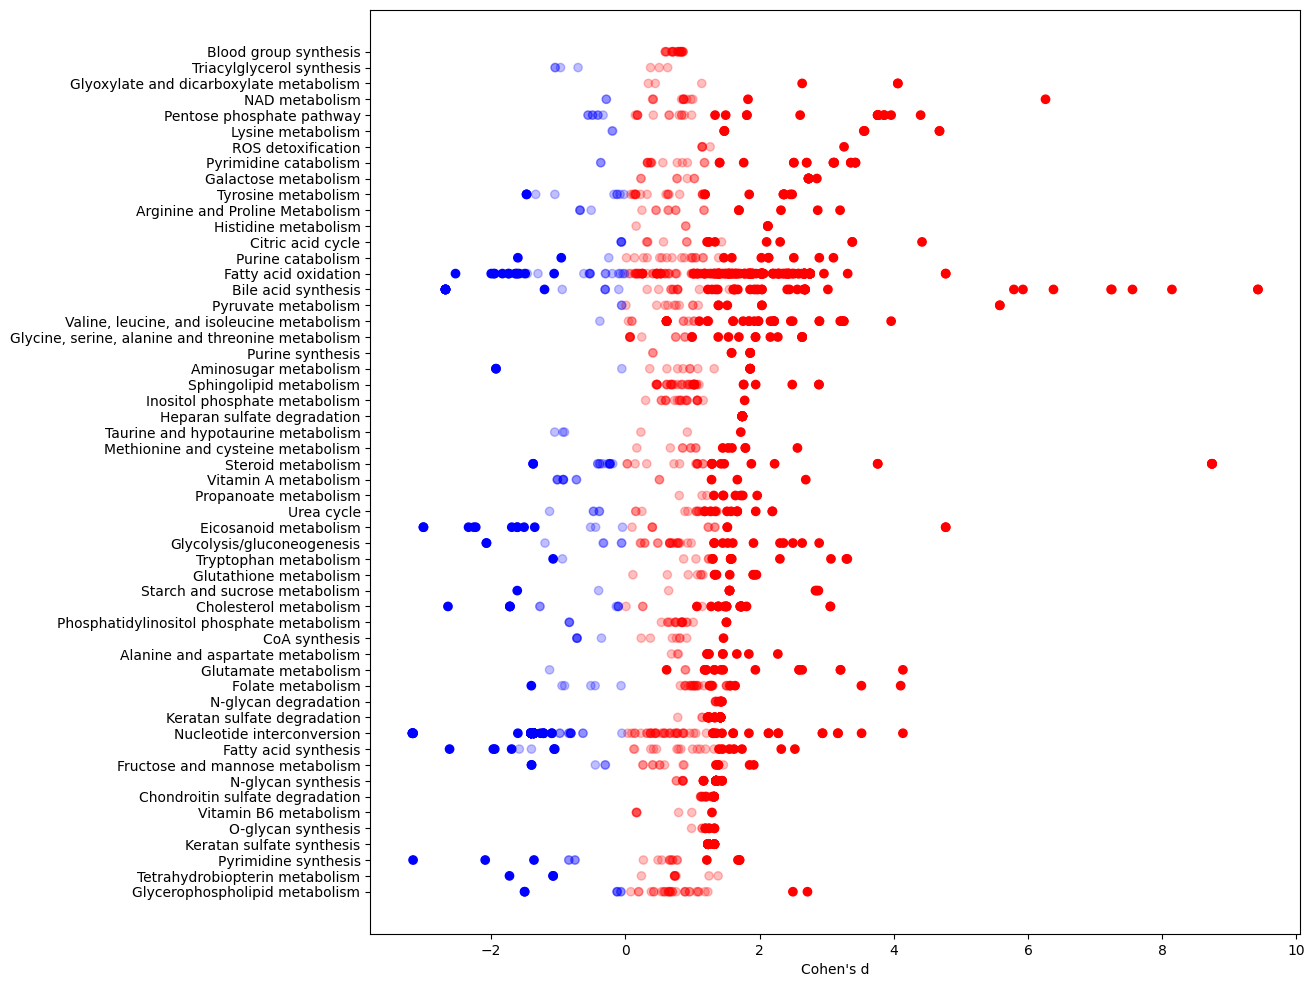

In [68]:
plt.figure(figsize=(12,12))
axs = plt.gca()
#Sorts the reactions for plotting
d = data[data['adjusted_pval'] < 0.1].groupby('subsystem')['cohens_d'].median().abs()
axs.scatter(d[d.argsort], d[d.argsort].index, alpha=0)
color = data['cohens_d'].map(lambda x: 'r' if x >= 0 else 'b')
alpha = data['adjusted_pval'].map(lambda x: 1.0 if x < 0.1 else 0.25)
axs.scatter(data['cohens_d'], data['subsystem'], c=color, alpha=alpha)
axs.set_xlabel("Cohen's d")

In [81]:
from os import write
write(W. W.csv)

AttributeError: 'DataFrame' object has no attribute 'W'